In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import dask 
import datetime
import cftime

import warnings
warnings.filterwarnings("ignore")

# progress bars for loops
from tqdm.notebook import tqdm  

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

from IPython import display
display.set_matplotlib_formats('retina')

In [2]:
import os
from pathlib import Path
os.getcwd()

'/Users/miriam/Documents/02_Academia/02_PhD/research/projects/drought-termination/code'

In [3]:
# grab the default path
p = Path(os.getcwd())

# move up a directory
os.chdir(p.parent)

# save that location
project_prefix = os.getcwd()

In [4]:
region = 'US_Southwest'
variable_id = ['mrsos', 'pr', 'tas']
#variable_id = ['mrso', 'pr']

print_string = "-"

fn_prefix = '/savepoints/model_anoms/' + region + '_' + print_string.join(variable_id) + '_'

In [5]:
import re
import glob

# get filelist
fns = glob.glob(project_prefix + fn_prefix+ '*')

# get the 'key' that was used earlier - just using 
# regex to get the string after the last "_", which 
# is how to get the ks based on what i made the fn_prefix 

# above
ks = [re.split('\_',fn)[-1] for fn in fns]
# Load
dict_of_ds = dict()
for k in ks:
    dict_of_ds[k] = xr.open_dataset(project_prefix + fn_prefix+k)

model_anoms = dict_of_ds

In [7]:
models = model_anoms.keys()

In [8]:
model_anoms_r = {model : {} for model in models}

for model in tqdm(model_anoms_r.keys()):
    #print('starting ' + model)
    
    # create the rolling average
    model_anoms_r[model] = model_anoms[model].rolling(time = 5, center = False).mean()
    #model_anoms_r[model] = model_anoms[model].rolling(time = 3, center = True).mean()
    

  0%|          | 0/16 [00:00<?, ?it/s]

### drought termination detection (kate's version)

In [9]:
def terminate_drought(x):
    try:
        return  np.ma.masked_where(normal_or_above <= x, normal_or_above).compressed()[0]
    except:
        return np.nan

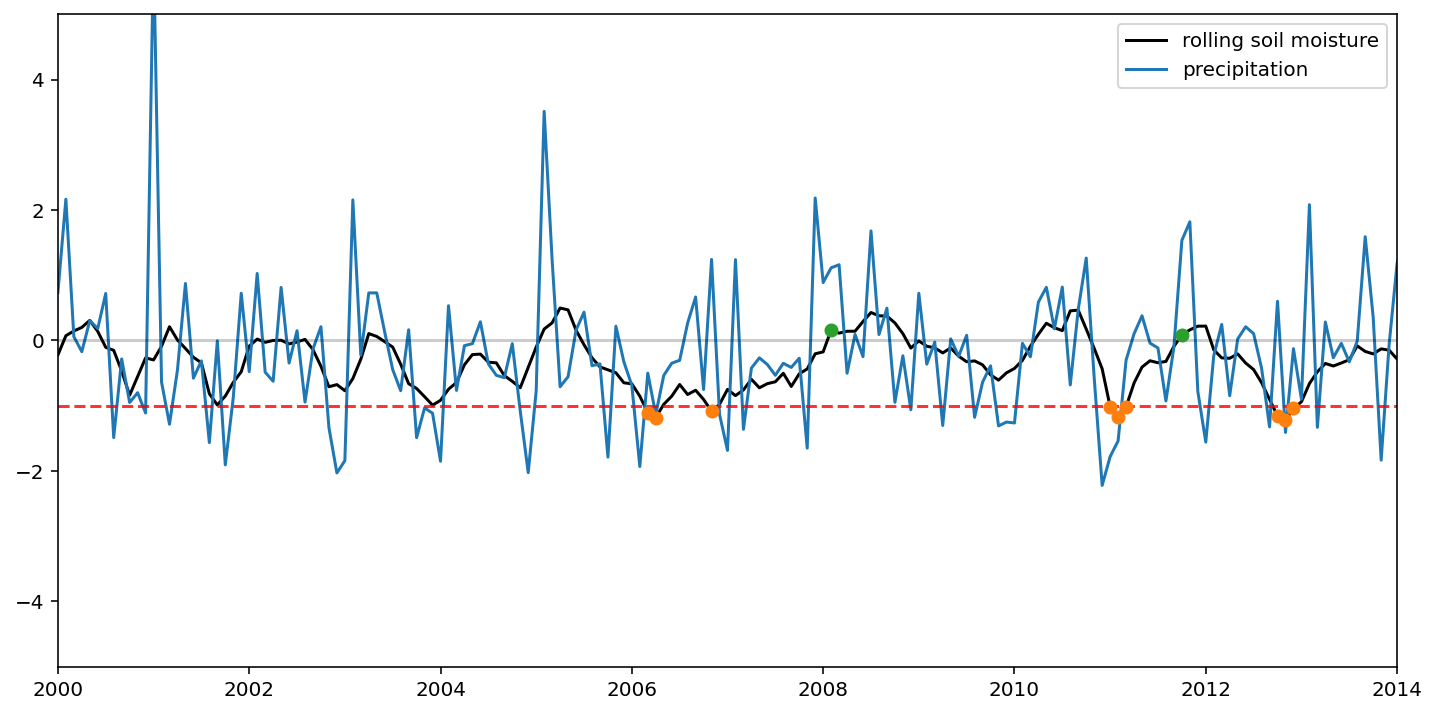

In [10]:
# CNRM-CM6-1 r3i1p1f2
numpy_data_mrsos = model_anoms['CNRM-CM6-1'].sel(member_id = 'r3i1p1f2').mrsos.values
numpy_data_pr = model_anoms['CNRM-CM6-1'].sel(member_id = 'r3i1p1f2').pr.values

mrsos_rolling =  model_anoms_r['CNRM-CM6-1'].sel(member_id = 'r3i1p1f2').mrsos.values

#dates = np.arange(1850, 2301, 1/12)
dates = np.arange(1850, 2101, 1/12)

#numpy_data_mrsos.shape
#dates.shape

drought_threshold = 1.
drought_months = np.where(mrsos_rolling <= -drought_threshold)[0]
#drought_months

normal_or_above=np.where(mrsos_rolling >=0)[0]
#normal_or_above

terminations = np.unique([terminate_drought(x) for x in drought_months])
iterminations= np.ma.masked_where(np.isnan(terminations),terminations).compressed().astype(np.int)
#dates[iterminations]

x=drought_months[0]
time_til_normal=normal_or_above-x
np.argmin(np.ma.masked_where(time_til_normal<0,time_til_normal))
#dates[normal_or_above[2]]

fig, ax = plt.subplots()

ax.plot(dates, mrsos_rolling, color = 'black', label = 'rolling soil moisture')
ax.plot(dates, numpy_data_pr, label = 'precipitation')

ax.set_xlim(2000, 2014)
ax.set_ylim(-5, 5)

ax.axhline(0, alpha = 0.2, color = 'k')
ax.axhline(-1, linestyle = '--', color = 'red', alpha = 0.8 )
ax.plot(dates[drought_months],mrsos_rolling[drought_months],"o")
ax.plot(dates[iterminations],mrsos_rolling[iterminations],"o")

plt.legend()

### composite (kate's version)

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

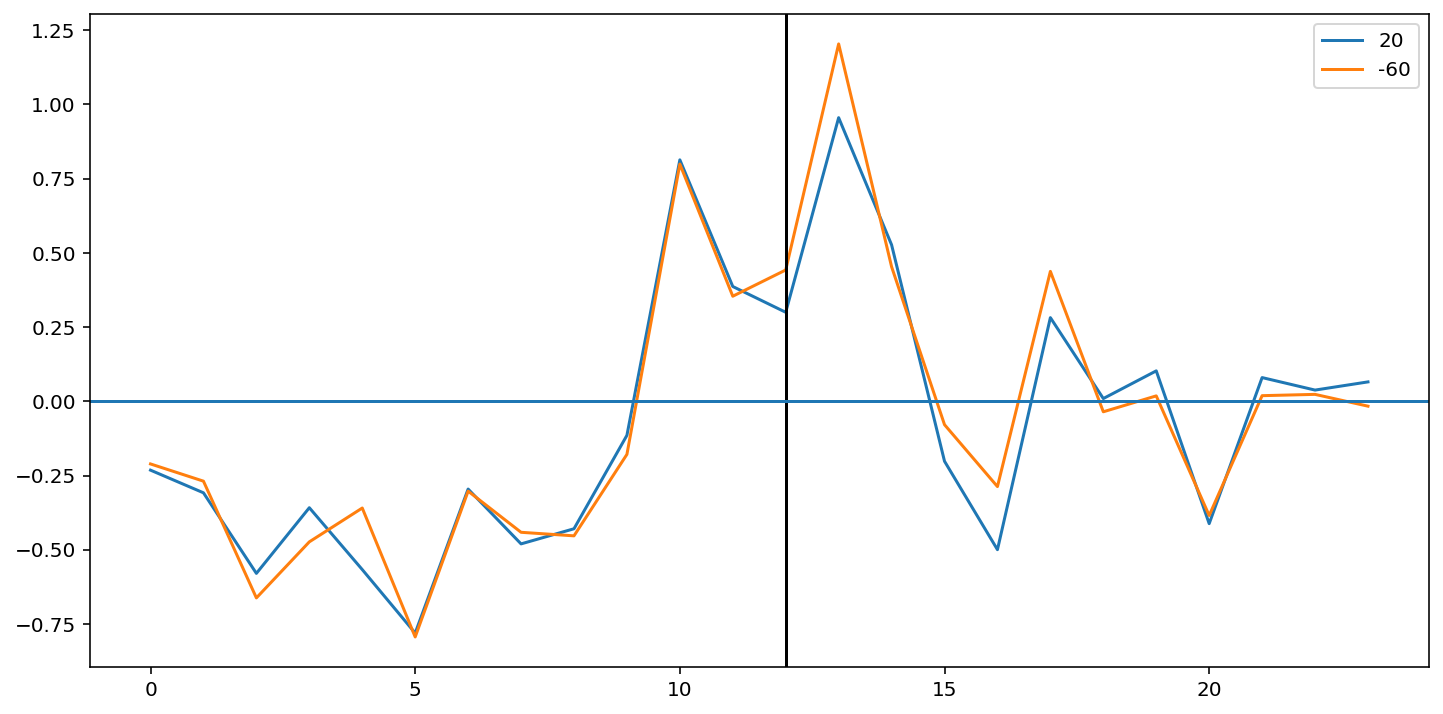

In [14]:
#tmp=[plt.plot(numpy_data_pr[x-12:x+12]) for x in iterminations]

Nterminations=len(iterminations)
tlen=numpy_data_pr[x-12:x+12]
#Nterminations was spelled Ntermimations and I haven't been able to re-create the same plot since 
#precip_terminations=np.zeros((Ntermimations,24))+1.e20
precip_terminations=np.zeros((Nterminations,24))+1.e20
for i in range(Nterminations):
    x=iterminations[i]
    try:
        precip_terminations[i]=numpy_data_pr[x-12:x+12]
    except:
        print(i)
precip_terminations=np.ma.masked_where(precip_terminations>1.e10, precip_terminations)

#print(precip_terminations)
plt.plot(np.ma.average(precip_terminations[:20], axis=0), label = '20')
plt.plot(np.ma.average(precip_terminations[-60:],axis=0), label = '-60')

plt.axvline(12, c = 'k')
plt.axhline(0)

plt.legend()
plt.tight_layout

In [1]:
import matplotlib.path as mplp
import numpy as np
import pandas as pd


df_regions = pd.read_csv("IPCC-WGI-reference-regions-v4_coordinates.csv")

def outline_to_mask(line, x, y):
    """Create mask from outline contour

    Parameters
    ----------
    line: array-like (N, 2)
    x, y: 1-D grid coordinates (input for meshgrid)

    Returns
    -------
    mask : 2-D boolean array (True inside)
    """

    mpath = mplp.Path(line)
    X, Y = np.meshgrid(x, y)
    points = np.array((X.flatten(), Y.flatten())).T
    mask = mpath.contains_points(points).reshape(X.shape)
    return mask

def IPCC_region(data, code):
    """Mask data outside AR6 reference region
    Requires https://github.com/IPCC-WG1/Atlas/blob/devel/reference-regions/IPCC-WGI-reference-regions-v4_coordinates.csv

    Parameters
    ----------
    data: array with shape (ntime,n_latitude,n_longitude)
    code: IPCC AR6 reference region code

    Returns
    -------
    ipcc_masked : array of shape (ntime, n_latitude,n_longitude) with values outside region masked
    """

    vals=df_regions[df_regions.Acronym==code].values[0]
    lons=[]
    lats=[]
    for x in vals:
        if type(x)==type("this"):
            if x.find("|")>0:
                lon,lat=x.split("|")

                lons+=[float(lon)]
                lats+=[float(lat)]
    N = len(lons)
    line = np.zeros((N,2))

    line[:,0] = np.array(lons)
    line[:,1] = np.array(lats)
    x = data.getLatitude()[:] #Edit based on datatype (may gave to change for xarray)
    y = data.getLongitude()[:]
    y = (y+ 180) % 360 - 180
    tmask =~ outline_to_mask(line,y,x)
    tmask.shape
    ipcc_masked = mask_data(data,tmask)
    
    return ipcc_masked
